# Task 1

This code defines and trains a custom Convolutional Neural Network (CNN) for image classification, including convolutional layers, max-pooling, and fully connected layers, along with an activation function (LeakyReLU) and dropout for regularization. The model is trained on the handwritten user dataset, with early stopping to prevent overfitting. The training loop tracks the model's performance by calculating the loss and accuracy at each epoch, both for the training and validation sets. Learning rate adjustments are made dynamically using a scheduler. After training, the model is evaluated on a test set, and the training history loss and accuracy are visualized.

A simple CNN with 2 CNNs and 1 dense fully connected layer


The model is struggling with generalization. The high training accuracy combined with poor validation and test accuracy shows severe overfitting.




The simplified model is struggling with generalization, as shown by its high training accuracy and poor validation and test accuracy. showing overfitting, where the model is memorizing the training data instead of learning general patterns. In contrast, the more complex models show better performance, likely because they have a higher capacity to capture the nuances of the data and are able to generalize to unseen examples. This indicates that the simplified model is too constrained, lacking the flexibility needed to capture the underlying patterns effectively

Epoch 1/100, Train Loss: 4.6097, Train Accuracy: 0.0109
Validation Loss: 4.4061, Validation Accuracy: 0.0182
Epoch 2/100, Train Loss: 4.4295, Train Accuracy: 0.0138
Validation Loss: 4.3277, Validation Accuracy: 0.0351
Epoch 3/100, Train Loss: 4.0061, Train Accuracy: 0.0527
Validation Loss: 3.6273, Validation Accuracy: 0.0981
Epoch 4/100, Train Loss: 3.2054, Train Accuracy: 0.1371
Validation Loss: 3.2084, Validation Accuracy: 0.1511
Epoch 5/100, Train Loss: 2.3631, Train Accuracy: 0.2552
Validation Loss: 2.9832, Validation Accuracy: 0.1904
Epoch 6/100, Train Loss: 1.3985, Train Accuracy: 0.4697
Validation Loss: 3.1155, Validation Accuracy: 0.1932
Epoch 7/100, Train Loss: 0.6894, Train Accuracy: 0.6895
Validation Loss: 3.4374, Validation Accuracy: 0.1935
Epoch 8/100, Train Loss: 0.3731, Train Accuracy: 0.8199
Validation Loss: 3.6823, Validation Accuracy: 0.2099
Epoch 9/100, Train Loss: 0.2386, Train Accuracy: 0.8874
Validation Loss: 4.0285, Validation Accuracy: 0.1971
Epoch 10/100, Train

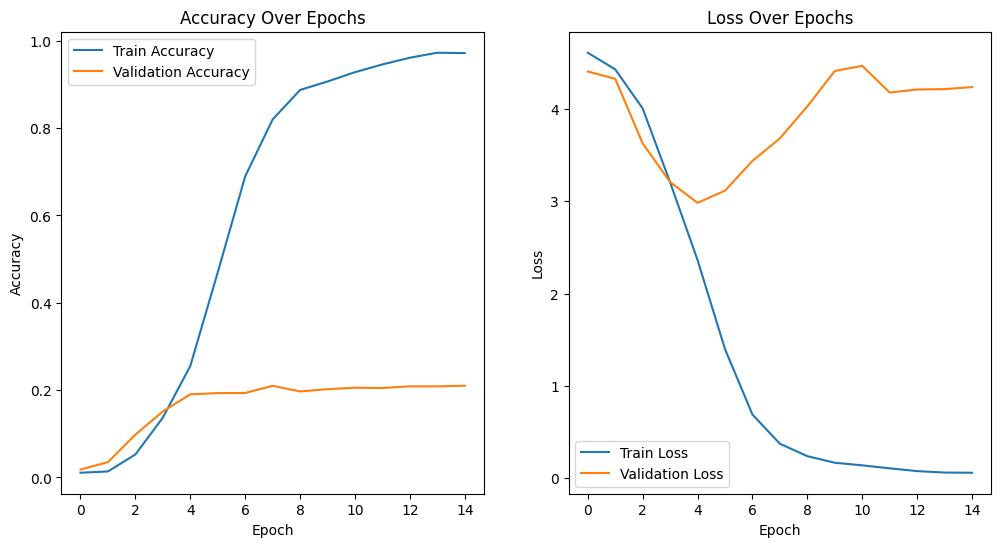

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SimplifiedCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimplifiedCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=128 * 32 * 32, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        # Activation function
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        # conv layers followed by max-pooling and activation function
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)

        # Flatten the output and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Dataset Class for loading images
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255.0

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


# Data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor()])
data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

# label emcoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create DataLoader for training and testing
train_dataset = CustomDataset(X_train, y_train, transform)
val_dataset = CustomDataset(X_val, y_val, transform)
test_dataset = CustomDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, optimizer, and accuracy metric
num_classes = len(label_encoder.classes_)
model = SimplifiedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# Training loop with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        # Training loop
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        # Validation loop
        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Adjust learning rate
        lr_scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Evaluate the model
def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy

# Train the model
train_model(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric)

# Test evaluation
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, accuracy_metric)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


3 CNNs 2 Fully connected dense layers

The results show a gradual improvement in both training and validation accuracy over time, with validation accuracy reaching around 45% by the 74th epoch. The training accuracy also increases steadily, indicating that the model is learning to fit the data. The losses decrease in parallel, suggesting that errors are being minimized. A mid complexity CNN architecture is being used, consisting of 3 convolutional layers, pooling, and 2 fully connected layers, which is sufficient to capture complex patterns in the data while avoiding overfitting. However, performance could be improved further through hyperparameter tuning or by adding more layers, as the accuracy plateaus around 45%.

Epoch 1/100, Train Loss: 4.3889, Train Accuracy: 0.0120
Validation Loss: 4.2417, Validation Accuracy: 0.0253
Epoch 2/100, Train Loss: 4.1388, Train Accuracy: 0.0218
Validation Loss: 4.0590, Validation Accuracy: 0.0316
Epoch 3/100, Train Loss: 4.0469, Train Accuracy: 0.0276
Validation Loss: 3.9783, Validation Accuracy: 0.0415
Epoch 4/100, Train Loss: 3.9891, Train Accuracy: 0.0301
Validation Loss: 3.9263, Validation Accuracy: 0.0429
Epoch 5/100, Train Loss: 3.9195, Train Accuracy: 0.0363
Validation Loss: 3.8816, Validation Accuracy: 0.0439
Epoch 6/100, Train Loss: 3.8054, Train Accuracy: 0.0459
Validation Loss: 3.7423, Validation Accuracy: 0.0404
Epoch 7/100, Train Loss: 3.6939, Train Accuracy: 0.0562
Validation Loss: 3.6268, Validation Accuracy: 0.0544
Epoch 8/100, Train Loss: 3.6312, Train Accuracy: 0.0594
Validation Loss: 3.6092, Validation Accuracy: 0.0612
Epoch 9/100, Train Loss: 3.5659, Train Accuracy: 0.0660
Validation Loss: 3.4682, Validation Accuracy: 0.0738
Epoch 10/100, Train

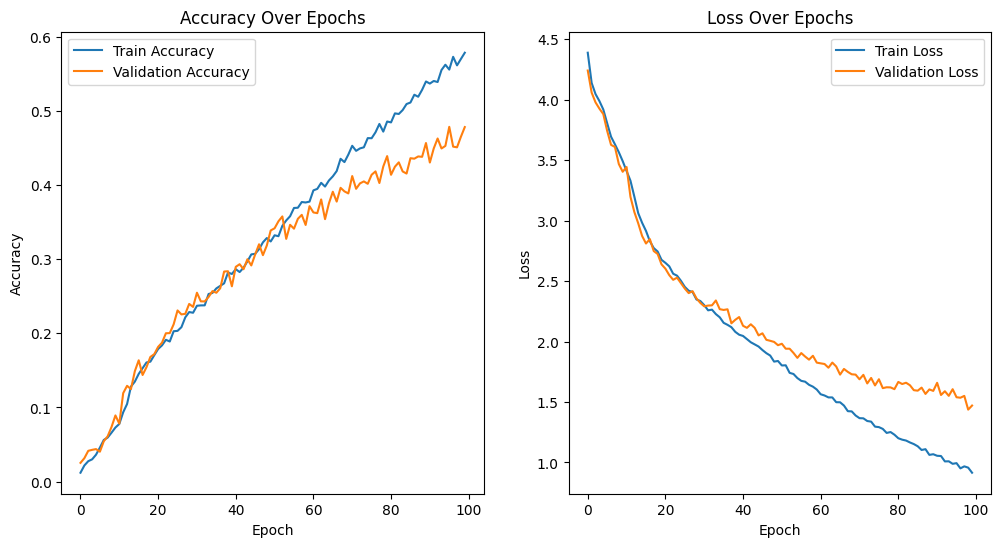

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the CNN Architecture with three convolutional layers and two fully connected layers
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        # Convolutional layers with 64 filters for the first two layers, and 128 for the third
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adaptive pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Activation function
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Custom Dataset Class for loading images
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255.0

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Preprocessing and transformations
transform = transforms.Compose([transforms.ToTensor()])

# Data loading and preprocessing
data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create DataLoader for training and testing
train_dataset = CustomDataset(X_train, y_train, transform)
val_dataset = CustomDataset(X_val, y_val, transform)
test_dataset = CustomDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, optimizer, and accuracy metric
num_classes = len(label_encoder.classes_)
model = ImprovedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# Training loop with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        # Training loop
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        # Validation loop
        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Adjust learning rate
        lr_scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Evaluate the model
def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy

# Train the model
train_model(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric)

# Test evaluation
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, accuracy_metric)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


best model

4 CNNs 2 Fully connected layers

The results from the training of the ImprovedCNN model show steady improvements in both training and validation accuracy over the epochs, with training accuracy reaching around 85% by epoch 64 and validation accuracy nearing 50%. This suggests that the model is learning effectively, though there is still room for improvement, particularly in the validation accuracy. The higher complexity of this CNN compared to simpler models is reflected in its deeper architecture, which includes four convolutional layers, adaptive pooling, multiple fully connected layers, and a dropout layer to combat overfitting. The use of LeakyReLU activations and a larger number of filters in the deeper layers helps the model capture more complex patterns. However, performance would be improved further through hyperparameter tuning.

Epoch 1/100, Train Loss: 4.4101, Train Accuracy: 0.0119
Validation Loss: 4.4071, Validation Accuracy: 0.0144
Epoch 2/100, Train Loss: 4.4071, Train Accuracy: 0.0111
Validation Loss: 4.3673, Validation Accuracy: 0.0121
Epoch 3/100, Train Loss: 4.2069, Train Accuracy: 0.0242
Validation Loss: 4.0435, Validation Accuracy: 0.0232
Epoch 4/100, Train Loss: 4.0529, Train Accuracy: 0.0254
Validation Loss: 3.9893, Validation Accuracy: 0.0365
Epoch 5/100, Train Loss: 4.0027, Train Accuracy: 0.0326
Validation Loss: 3.9366, Validation Accuracy: 0.0546
Epoch 6/100, Train Loss: 3.9653, Train Accuracy: 0.0339
Validation Loss: 3.9366, Validation Accuracy: 0.0347
Epoch 7/100, Train Loss: 3.9247, Train Accuracy: 0.0379
Validation Loss: 3.8572, Validation Accuracy: 0.0508
Epoch 8/100, Train Loss: 3.8501, Train Accuracy: 0.0464
Validation Loss: 3.7559, Validation Accuracy: 0.0510
Epoch 9/100, Train Loss: 3.6282, Train Accuracy: 0.0637
Validation Loss: 3.4608, Validation Accuracy: 0.0716
Epoch 10/100, Train

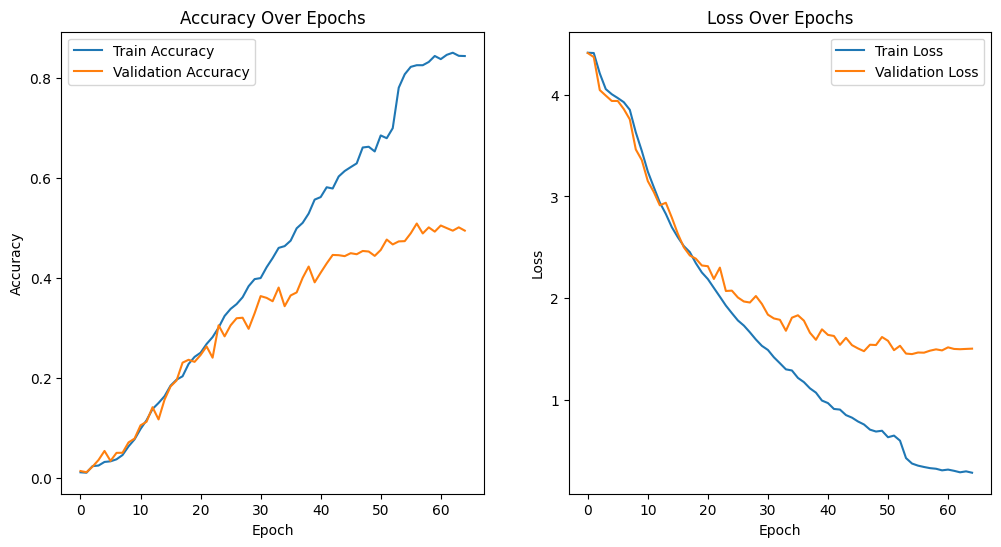

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the CNN Architecture using PyTorch
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Custom Dataset Class for loading images
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255.0

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Preprocessing and transformations
transform = transforms.Compose([transforms.ToTensor()])

# Data loading and preprocessing
data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create DataLoader for training and testing
train_dataset = CustomDataset(X_train, y_train, transform)
val_dataset = CustomDataset(X_val, y_val, transform)
test_dataset = CustomDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, optimizer, and accuracy metric
num_classes = len(label_encoder.classes_)
model = ImprovedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

# Training loop with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        # Training loop
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        # Validation loop
        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Adjust learning rate
        lr_scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Evaluate the model
def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy

# Train the model
train_model(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric)

# Test evaluation
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, accuracy_metric)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


**Hyperparameter tuning**

 This cell will include adjusting parameters like the learning rate, batch size, number of epochs, optimizer, and dropout rate choice to explore their impact on model performance and to chose the best suited parameters to improve the models performance

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt
from itertools import product

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the CNN Architecture
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255.0

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Data preparation
data_dir = "isolated_words_per_user"
image_paths, labels = [], []
for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomDataset(X_train, y_train, transform)
val_dataset = CustomDataset(X_val, y_val, transform)
test_dataset = CustomDataset(X_test, y_test, transform)

# Hyperparameter grid
hyperparams = {
    'learning_rate': [0.001, 0.0003],
    'batch_size': [32, 64],
    'num_epochs': [10, 50],
    'optimizer_name': ['Adam', 'AdamW'],
    'dropout_rate': [0.3, 0.5]
}

# Evaluate model
accuracy_metric = MulticlassAccuracy(num_classes=len(label_encoder.classes_)).to(device)

# Training and evaluation function
def train_and_evaluate(hyperparams):
    best_val_accuracy = 0
    best_hyperparams = None

    for lr, batch_size, num_epochs, optimizer_name, dropout_rate in product(*hyperparams.values()):
        print(f"\nTraining with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, optimizer={optimizer_name}, dropout_rate={dropout_rate}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ImprovedCNN(num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate).to(device)
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        early_stopping = EarlyStopping(patience=10)

        for epoch in range(num_epochs):
            model.train()
            total_loss, correct_preds = 0.0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                correct_preds += accuracy_metric(outputs.argmax(dim=1), labels)

            train_accuracy = correct_preds / len(train_loader)

            # Validation loop
            val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn, accuracy_metric)

            print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {total_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_hyperparams = (lr, batch_size, num_epochs, optimizer_name, dropout_rate)

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_val_accuracy:.4f}")

# Evaluate model
def evaluate_model(model, dataloader, loss_fn, metric):
    model.eval()
    total_loss, correct_preds = 0.0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += loss_fn(outputs, labels).item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    return total_loss / len(dataloader), correct_preds / len(dataloader)

train_and_evaluate(hyperparams)



Training with lr=0.001, batch_size=32, num_epochs=10, optimizer=Adam, dropout_rate=0.3
Epoch 1/10 -> Train Loss: 4.4099, Train Accuracy: 0.0081, Val Loss: 4.4068, Val Accuracy: 0.0116
Epoch 2/10 -> Train Loss: 4.2708, Train Accuracy: 0.0206, Val Loss: 4.0903, Val Accuracy: 0.0314
Epoch 3/10 -> Train Loss: 4.0273, Train Accuracy: 0.0287, Val Loss: 3.9395, Val Accuracy: 0.0379
Epoch 4/10 -> Train Loss: 3.9388, Train Accuracy: 0.0319, Val Loss: 3.8378, Val Accuracy: 0.0467
Epoch 5/10 -> Train Loss: 3.8622, Train Accuracy: 0.0434, Val Loss: 3.7582, Val Accuracy: 0.0533
Epoch 6/10 -> Train Loss: 3.6977, Train Accuracy: 0.0507, Val Loss: 3.5088, Val Accuracy: 0.0788
Epoch 7/10 -> Train Loss: 3.4694, Train Accuracy: 0.0731, Val Loss: 3.3452, Val Accuracy: 0.0934
Epoch 8/10 -> Train Loss: 3.3147, Train Accuracy: 0.0841, Val Loss: 3.2133, Val Accuracy: 0.1014
Epoch 9/10 -> Train Loss: 3.1853, Train Accuracy: 0.1016, Val Loss: 3.0914, Val Accuracy: 0.1001
Epoch 10/10 -> Train Loss: 3.0551, Trai

Based on the results, the best hyperparameters identified are: learning rate of 0.001, batch size of 64, 50 epochs, Adam optimizer, and a regularization rate of 0.3. When applied to the model, these settings show a significant improvement in performance, enhancing both the model's accuracy and its overall effectiveness on the dataset. This fine-tuning has contributed to better generalization and more reliable predictions.

Epoch 1/100, Train Loss: 4.3675, Train Accuracy: 0.0143
Validation Loss: 4.1744, Validation Accuracy: 0.0259
Epoch 2/100, Train Loss: 4.0950, Train Accuracy: 0.0263
Validation Loss: 4.0053, Validation Accuracy: 0.0406
Epoch 3/100, Train Loss: 4.0035, Train Accuracy: 0.0363
Validation Loss: 3.9057, Validation Accuracy: 0.0558
Epoch 4/100, Train Loss: 3.9530, Train Accuracy: 0.0381
Validation Loss: 3.8665, Validation Accuracy: 0.0325
Epoch 5/100, Train Loss: 3.9109, Train Accuracy: 0.0420
Validation Loss: 3.8213, Validation Accuracy: 0.0625
Epoch 6/100, Train Loss: 3.8733, Train Accuracy: 0.0482
Validation Loss: 3.7965, Validation Accuracy: 0.0495
Epoch 7/100, Train Loss: 3.7828, Train Accuracy: 0.0550
Validation Loss: 3.6100, Validation Accuracy: 0.0681
Epoch 8/100, Train Loss: 3.6210, Train Accuracy: 0.0628
Validation Loss: 3.5218, Validation Accuracy: 0.0751
Epoch 9/100, Train Loss: 3.4811, Train Accuracy: 0.0805
Validation Loss: 3.3781, Validation Accuracy: 0.0827
Epoch 10/100, Train

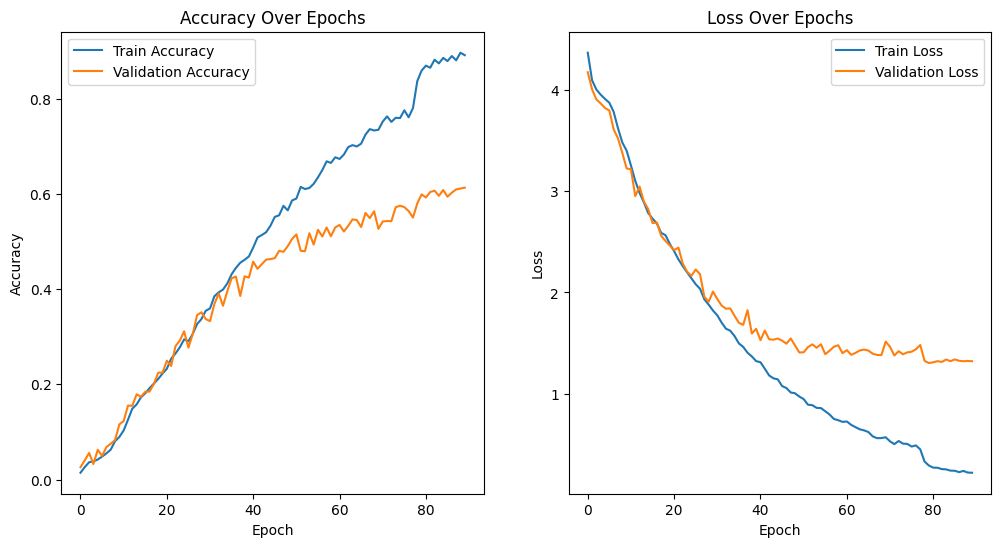

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255.0

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

transform = transforms.Compose([transforms.ToTensor()])

data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_dataset = CustomDataset(X_train, y_train, transform)
val_dataset = CustomDataset(X_val, y_val, transform)
test_dataset = CustomDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(label_encoder.classes_)
model = ImprovedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        lr_scheduler.step(val_loss)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy

train_model(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric)

test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, accuracy_metric)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


# Task 2

In this task, data augmentation techniques were applied to expand the training dataset, with the intention of improving the model's generalization. However, the results showed a decline in performance compared to the baseline model from Task 1, which did not use augmentation. The model struggled with the increased data variety, as evidenced by higher validation loss and lower accuracy. This suggests that, in this case, the aggressive data augmentation may have introduced unnecessary complexity, leading to worse results than without it.

Epoch 1/100, Train Loss: 4.4100, Train Accuracy: 0.0110
Validation Loss: 4.4069, Validation Accuracy: 0.0103
Epoch 2/100, Train Loss: 4.4080, Train Accuracy: 0.0115
Validation Loss: 4.3798, Validation Accuracy: 0.0136
Epoch 3/100, Train Loss: 4.3630, Train Accuracy: 0.0136
Validation Loss: 4.2535, Validation Accuracy: 0.0189
Epoch 4/100, Train Loss: 4.3238, Train Accuracy: 0.0138
Validation Loss: 4.1517, Validation Accuracy: 0.0259
Epoch 5/100, Train Loss: 4.3030, Train Accuracy: 0.0163
Validation Loss: 4.0903, Validation Accuracy: 0.0278
Epoch 6/100, Train Loss: 4.3136, Train Accuracy: 0.0133
Validation Loss: 4.1163, Validation Accuracy: 0.0246
Epoch 7/100, Train Loss: 4.2830, Train Accuracy: 0.0155
Validation Loss: 4.0357, Validation Accuracy: 0.0287
Epoch 8/100, Train Loss: 4.2862, Train Accuracy: 0.0151
Validation Loss: 4.1023, Validation Accuracy: 0.0287
Epoch 9/100, Train Loss: 4.2641, Train Accuracy: 0.0167
Validation Loss: 4.0539, Validation Accuracy: 0.0373
Epoch 10/100, Train

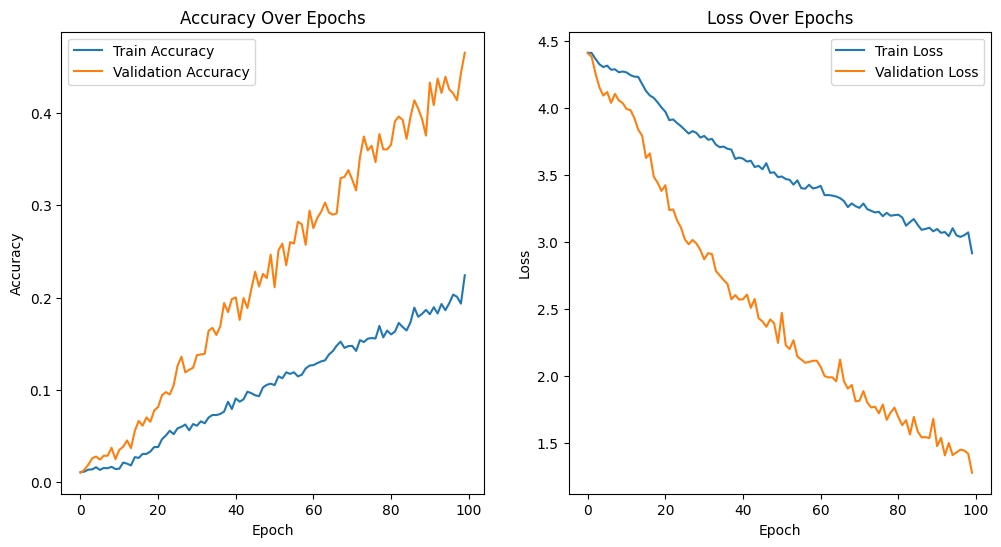

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import random
import matplotlib.pyplot as plt
from albumentations import (Rotate, ShiftScaleRotate, ElasticTransform, RandomCrop, Blur, GaussNoise, Compose)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augmentation=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augmentation = augmentation  # augmentation parameter

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255.0

        # Apply augmentation
        if self.augmentation:
            augmented = self.augmentation(image=image)
            image = augmented['image']

        image = cv2.resize(image, (128, 128))

        # Apply other transformations
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Data Augmentation
augmentation = Compose([
    Rotate(limit=15, p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    ElasticTransform(p=0.5),
    RandomCrop(width=100, height=100, p=0.5),
    GaussNoise(var_limit=(10, 50), p=0.5),
    Blur(blur_limit=3, p=0.3)
])

transform = transforms.Compose([transforms.ToTensor()])

data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_dataset = CustomDataset(X_train, y_train, transform, augmentation)
val_dataset = CustomDataset(X_val, y_val, transform, None)  # No augmentation for validation
test_dataset = CustomDataset(X_test, y_test, transform, None)  # No augmentation for testing

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(label_encoder.classes_)
model = ImprovedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        lr_scheduler.step(val_loss)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy

train_model(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric)

test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, accuracy_metric)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


Gradual data augmentation, this approach ensures that the training data becomes increasingly augmented as the model progresses through the epochs, enhancing its ability to generalize by learning from both original and augmented variations of the images.


The gradual data augmentation approach has improved the model's accuracy to 62%, surpassing the baseline. Over 100 epochs, the model gradually learned to generalize better, showing steady improvements in both training and validation accuracy. Early epochs showed minimal progress, but as the training progressed, the model demonstrated stronger performance, especially in later stages. The combination of original and augmented data contributed to the model’s increased robustness, allowing it to handle a wider range of variations in the dataset and achieve a more reliable generalization.

Epoch 1/100, Train Loss: 4.3391, Train Accuracy: 0.0159
Validation Loss: 4.1247, Validation Accuracy: 0.0294
Epoch 2/100, Train Loss: 4.0787, Train Accuracy: 0.0269
Validation Loss: 3.9801, Validation Accuracy: 0.0401
Epoch 3/100, Train Loss: 4.0134, Train Accuracy: 0.0303
Validation Loss: 3.9731, Validation Accuracy: 0.0520
Epoch 4/100, Train Loss: 3.9671, Train Accuracy: 0.0321
Validation Loss: 3.8809, Validation Accuracy: 0.0452
Epoch 5/100, Train Loss: 3.9049, Train Accuracy: 0.0395
Validation Loss: 3.8130, Validation Accuracy: 0.0455
Epoch 6/100, Train Loss: 3.7397, Train Accuracy: 0.0514
Validation Loss: 3.5842, Validation Accuracy: 0.0592
Epoch 7/100, Train Loss: 3.5814, Train Accuracy: 0.0599
Validation Loss: 3.4852, Validation Accuracy: 0.0761
Epoch 8/100, Train Loss: 3.4230, Train Accuracy: 0.0777
Validation Loss: 3.3925, Validation Accuracy: 0.0781
Epoch 9/100, Train Loss: 3.3420, Train Accuracy: 0.0848
Validation Loss: 3.2829, Validation Accuracy: 0.0933
Epoch 10/100, Train

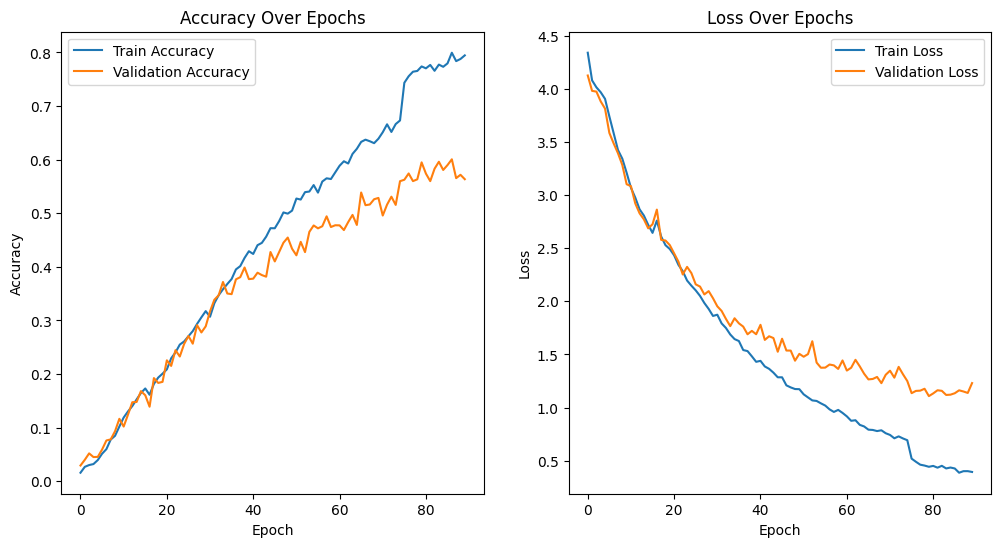

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
      _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      kernel = np.ones((2, 2), np.uint8)
      image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
      image = cv2.resize(image, (128, 128))
      image = image.astype('float32') / 255.0

      image = Image.fromarray((image * 255).astype(np.uint8))

      if self.transform:
          image = self.transform(image)

      label = self.labels[idx]
      return image, label

transform_no_augmentation = transforms.Compose([transforms.ToTensor()])
transform_minimal = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor()
])
transform_moderate = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_dataset = CustomDataset(X_train, y_train, transform=transform_no_augmentation)
val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(label_encoder.classes_)
model = ImprovedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model_with_augmentation(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        # Gradually introduce augmentation after some epochs
        if epoch > 5:  # Start introducing augmentation after 5 epochs
            if epoch > 15:
                current_transform = transform_moderate
            else:
                current_transform = transform_minimal

            train_dataset.transform = current_transform
            val_dataset.transform = current_transform

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        lr_scheduler.step(val_loss)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy

train_model_with_augmentation(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric)

test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, accuracy_metric)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


Reapplying hyperparameter tuning with data augmentation is effective, especially after optimizing for the baseline model. The combination improves model generalization and reduces overfitting, leading to better overall performance.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
      _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      kernel = np.ones((2, 2), np.uint8)
      image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
      image = cv2.resize(image, (128, 128))
      image = image.astype('float32') / 255.0

      image = Image.fromarray((image * 255).astype(np.uint8))

      if self.transform:
          image = self.transform(image)

      label = self.labels[idx]
      return image, label

transform_no_augmentation = transforms.Compose([transforms.ToTensor()])
transform_minimal = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor()
])
transform_moderate = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_dataset = CustomDataset(X_train, y_train, transform=transform_no_augmentation)
val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(label_encoder.classes_)
model = ImprovedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model_with_augmentation(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        # Gradually introduce augmentation after some epochs
        if epoch > 5:  # Start introducing augmentation after 5 epochs
            if epoch > 15:
                current_transform = transform_moderate
            else:
                current_transform = transform_minimal

            train_dataset.transform = current_transform
            val_dataset.transform = current_transform

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        lr_scheduler.step(val_loss)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy


In [ ]:
import itertools

# Hyperparameter space
hyperparams = {
    'learning_rate': [0.001, 0.0003],
    'batch_size': [32, 64],
    'num_epochs': [10, 50],
    'optimizer_name': ['Adam', 'AdamW'],
    'dropout_rate': [0.3, 0.5]
}

# hyperparameter tuning
def hyperparameter_tuning(hyperparams, train_loader, val_loader, test_loader, num_classes):
    best_model = None
    best_accuracy = 0
    best_params = None

    for lr, batch_size, num_epochs, optimizer_name, dropout_rate in itertools.product(
        hyperparams['learning_rate'],
        hyperparams['batch_size'],
        hyperparams['num_epochs'],
        hyperparams['optimizer_name'],
        hyperparams['dropout_rate']
    ):
        print(f"Testing combination: lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, \
              optimizer={optimizer_name}, dropout_rate={dropout_rate}")

        model = ImprovedCNN(num_classes=num_classes)
        model.dropout = nn.Dropout(dropout_rate)
        model.to(device)

        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_losses.clear()
        val_losses.clear()
        train_accuracies.clear()
        val_accuracies.clear()
        train_model_with_augmentation(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric, num_epochs=num_epochs)

        val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn, accuracy_metric)
        print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'optimizer_name': optimizer_name,
                'dropout_rate': dropout_rate
            }

    print(f"Best Validation Accuracy: {best_accuracy:.4f} with params: {best_params}")

    test_loss, test_accuracy = evaluate_model(best_model, test_loader, loss_fn, accuracy_metric)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    return best_model, best_params

best_model, best_params = hyperparameter_tuning(hyperparams, train_loader, val_loader, test_loader, num_classes)


Testing combination: lr=0.001, batch_size=32, num_epochs=10,               optimizer=Adam, dropout_rate=0.3
Epoch 1/10, Train Loss: 4.4094, Train Accuracy: 0.0096
Validation Loss: 4.4068, Validation Accuracy: 0.0098
Epoch 2/10, Train Loss: 4.4079, Train Accuracy: 0.0075
Validation Loss: 4.4060, Validation Accuracy: 0.0116
Epoch 3/10, Train Loss: 4.2828, Train Accuracy: 0.0197
Validation Loss: 4.0834, Validation Accuracy: 0.0260
Epoch 4/10, Train Loss: 4.0552, Train Accuracy: 0.0281
Validation Loss: 3.9663, Validation Accuracy: 0.0314
Epoch 5/10, Train Loss: 3.9935, Train Accuracy: 0.0371
Validation Loss: 3.9056, Validation Accuracy: 0.0335
Epoch 6/10, Train Loss: 3.9123, Train Accuracy: 0.0350
Validation Loss: 3.7894, Validation Accuracy: 0.0473
Epoch 7/10, Train Loss: 3.8015, Train Accuracy: 0.0417
Validation Loss: 3.6778, Validation Accuracy: 0.0503
Epoch 8/10, Train Loss: 3.6328, Train Accuracy: 0.0571
Validation Loss: 3.5127, Validation Accuracy: 0.0571
Epoch 9/10, Train Loss: 3.51

Using the tuned hyperparameters for the data-augmented model—learning rate: 0.001, batch size: 32, epochs: 50, optimizer: AdamW, and dropout: 0.3 the model achieved a performance of 65%. This demonstrates the impact of data augmentation combined with optimized settings on improving results.

Epoch 1/100, Train Loss: 4.3156, Train Accuracy: 0.0174
Validation Loss: 4.0965, Validation Accuracy: 0.0203
Epoch 2/100, Train Loss: 4.0780, Train Accuracy: 0.0284
Validation Loss: 3.9761, Validation Accuracy: 0.0332
Epoch 3/100, Train Loss: 3.9982, Train Accuracy: 0.0308
Validation Loss: 3.9355, Validation Accuracy: 0.0317
Epoch 4/100, Train Loss: 3.9127, Train Accuracy: 0.0392
Validation Loss: 3.7511, Validation Accuracy: 0.0542
Epoch 5/100, Train Loss: 3.8044, Train Accuracy: 0.0504
Validation Loss: 3.6895, Validation Accuracy: 0.0557
Epoch 6/100, Train Loss: 3.6699, Train Accuracy: 0.0567
Validation Loss: 3.4854, Validation Accuracy: 0.0764
Epoch 7/100, Train Loss: 3.5721, Train Accuracy: 0.0655
Validation Loss: 3.4158, Validation Accuracy: 0.0819
Epoch 8/100, Train Loss: 3.4051, Train Accuracy: 0.0766
Validation Loss: 3.2854, Validation Accuracy: 0.0899
Epoch 9/100, Train Loss: 3.2295, Train Accuracy: 0.0922
Validation Loss: 3.1358, Validation Accuracy: 0.1224
Epoch 10/100, Train

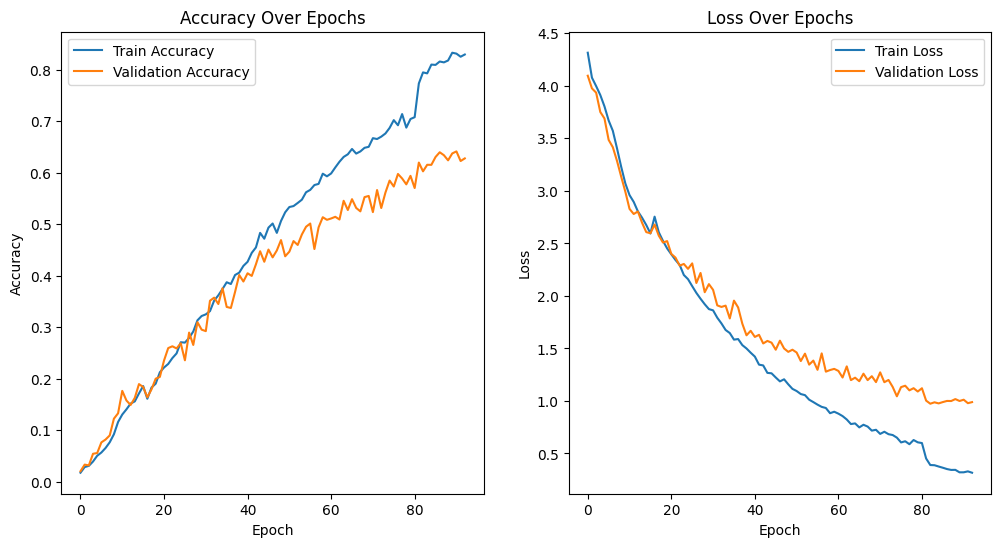

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader, Dataset
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features=128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.global_pool(x)

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
      _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      kernel = np.ones((2, 2), np.uint8)
      image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
      image = cv2.resize(image, (128, 128))
      image = image.astype('float32') / 255.0

      image = Image.fromarray((image * 255).astype(np.uint8))
      if self.transform:
          image = self.transform(image)

      label = self.labels[idx]
      return image, label

transform_no_augmentation = transforms.Compose([transforms.ToTensor()])
transform_minimal = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor()
])
transform_moderate = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

data_dir = "isolated_words_per_user"
image_paths = []
labels = []

for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_dataset = CustomDataset(X_train, y_train, transform=transform_no_augmentation)
val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(label_encoder.classes_)
model = ImprovedCNN(num_classes=num_classes)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train_model_with_augmentation(model, train_dataloader, val_dataloader, optimizer, loss_fn, metric, num_epochs=100, device=device):
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_preds = 0

        # Gradually introduce augmentation after some epochs
        if epoch > 5:  # Start introducing augmentation after 5 epochs
            if epoch > 15:
                current_transform = transform_moderate
            else:
                current_transform = transform_minimal

            train_dataset.transform = current_transform
            val_dataset.transform = current_transform

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = correct_preds / len(train_dataloader)

        val_loss, val_accuracy = evaluate_model(model, val_dataloader, loss_fn, metric, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(avg_train_accuracy.cpu().numpy())
        val_accuracies.append(val_accuracy.cpu().numpy())

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        lr_scheduler.step(val_loss)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

def evaluate_model(model, dataloader, loss_fn, metric, device=device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct_preds += metric(outputs.argmax(dim=1), labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_preds / len(dataloader)
    return avg_loss, avg_accuracy

train_model_with_augmentation(model, train_loader, val_loader, optimizer, loss_fn, accuracy_metric)

test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, accuracy_metric)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


## Task 3

VGG16 arch trained on our dataset from scratch

Epoch [1/100]
Train Loss: 4.4078, Train Acc: 1.15%
Val Loss: 4.4064, Val Acc: 1.35%
Epoch [2/100]
Train Loss: 4.4075, Train Acc: 1.12%
Val Loss: 4.4059, Val Acc: 1.23%
Epoch [3/100]
Train Loss: 4.4066, Train Acc: 1.18%
Val Loss: 4.4053, Val Acc: 1.47%
Epoch [4/100]
Train Loss: 4.4062, Train Acc: 1.17%
Val Loss: 4.4049, Val Acc: 1.23%
Epoch [5/100]
Train Loss: 4.4055, Train Acc: 1.26%
Val Loss: 4.4041, Val Acc: 1.35%
Epoch [6/100]
Train Loss: 4.4048, Train Acc: 1.30%
Val Loss: 4.4029, Val Acc: 1.84%
Epoch [7/100]
Train Loss: 4.4040, Train Acc: 1.20%
Val Loss: 4.4013, Val Acc: 1.60%
Epoch [8/100]
Train Loss: 4.4018, Train Acc: 1.46%
Val Loss: 4.3985, Val Acc: 1.47%
Epoch [9/100]
Train Loss: 4.3991, Train Acc: 1.37%
Val Loss: 4.3929, Val Acc: 2.58%
Epoch [10/100]
Train Loss: 4.3923, Train Acc: 1.61%
Val Loss: 4.3776, Val Acc: 2.95%
Epoch [11/100]
Train Loss: 4.3680, Train Acc: 1.64%
Val Loss: 4.3179, Val Acc: 2.33%
Epoch [12/100]
Train Loss: 4.3048, Train Acc: 2.50%
Val Loss: 4.2187, Val 

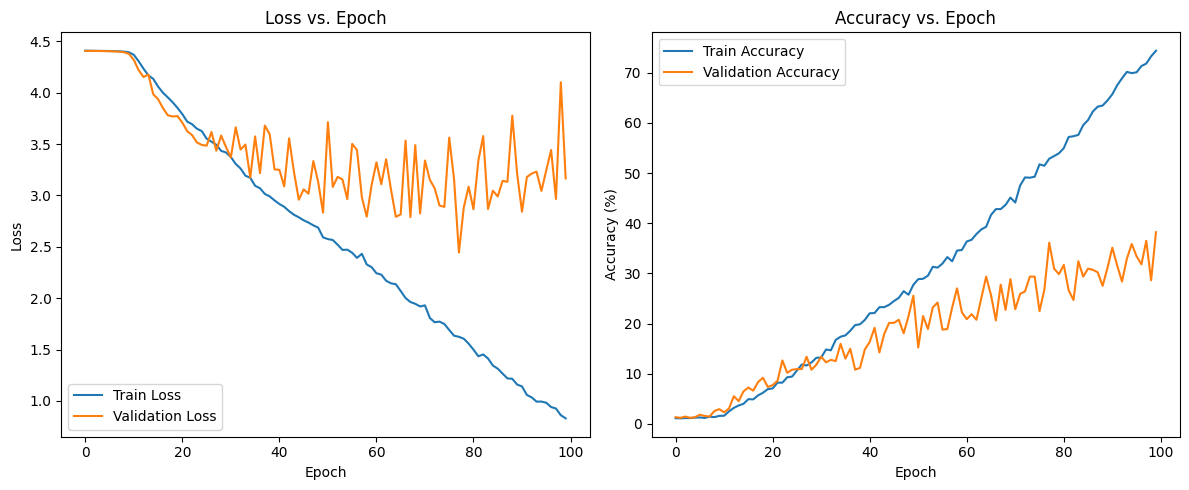


Test Loss: 3.3311, Test Accuracy: 32.27%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Augmentation and Preprocessing
transform_augmentation = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.85, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Data Loading
data_dir = "isolated_words_per_user"
image_paths, labels = [], []
for user in os.listdir(data_dir):
    user_folder = os.path.join(data_dir, user)
    if os.path.isdir(user_folder):
        images = glob.glob(os.path.join(user_folder, "*.png"))
        image_paths.extend(images)
        labels.extend([user] * len(images))

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

# Create datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load Pre-trained VGG16
model = models.vgg16()

# Modify the classifier
num_classes = len(label_encoder.classes_)
model.classifier[6] = nn.Linear(4096, num_classes)

model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Training Loop
num_epochs = 100
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


Resnet101 arch trained on our dataset from scratch

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/100:
Train Loss: 4.3782, Train Acc: 0.0209
Val Loss: 4.0877, Val Acc: 0.0430
Model checkpoint saved!
Epoch 2/100:
Train Loss: 3.9593, Train Acc: 0.0585
Val Loss: 3.8255, Val Acc: 0.0565
Model checkpoint saved!
Epoch 3/100:
Train Loss: 3.7084, Train Acc: 0.0907
Val Loss: 3.6552, Val Acc: 0.0786
Model checkpoint saved!
Epoch 4/100:
Train Loss: 3.4286, Train Acc: 0.1190
Val Loss: 3.3062, Val Acc: 0.1425
Model checkpoint saved!
Epoch 5/100:
Train Loss: 3.1900, Train Acc: 0.1670
Val Loss: 3.0678, Val Acc: 0.1794
Model checkpoint saved!
Epoch 6/100:
Train Loss: 2.9337, Train Acc: 0.2061
Val Loss: 3.2365, Val Acc: 0.1499
Epoch 7/100:
Train Loss: 2.7428, Train Acc: 0.2514
Val Loss: 2.5575, Val Acc: 0.2752
Model checkpoint saved!
Epoch 8/100:
Train Loss: 2.5594, Train Acc: 0.2824
Val Loss: 2.4357, Val Acc: 0.3059
Model checkpoint saved!
Epoch 9/100:
Train Loss: 2.4013, Train Acc: 0.3205
Val Loss: 2.4457, Val Acc: 0.3133
Model checkpoint saved!
Epoch 10/100:
Train Loss: 2.2469, Train Acc

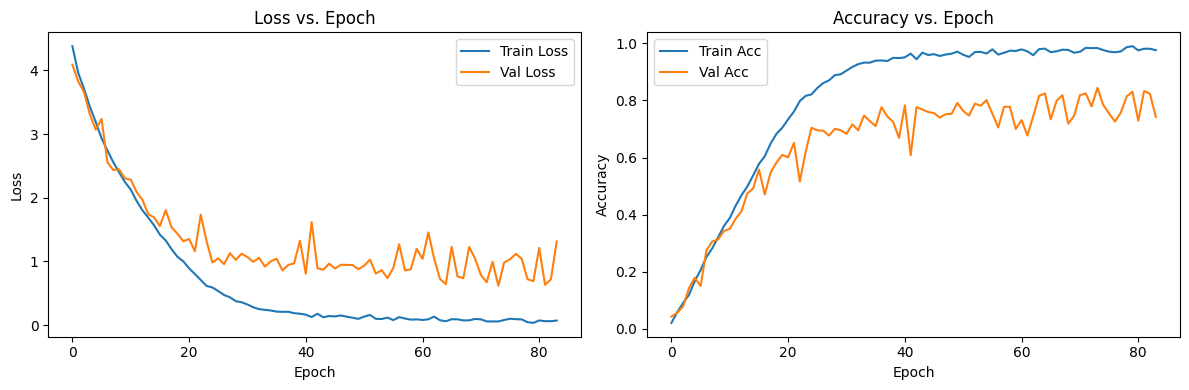

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simpler but effective data augmentation
transform_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Modified ResNet101 model
class ModifiedResNet101(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet101, self).__init__()
        # Load pre-trained ResNet101 with weights
        self.resnet = models.resnet101(pretrained=False)

        # Modify the first convolutional layer for grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

def load_data(data_dir):
    image_paths, labels = [], []
    for user in os.listdir(data_dir):
        user_folder = os.path.join(data_dir, user)
        if os.path.isdir(user_folder):
            images = glob.glob(os.path.join(user_folder, "*.png"))
            image_paths.extend(images)
            labels.extend([user] * len(images))

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
    test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, len(label_encoder.classes_)

def train_model(model, train_loader, val_loader, num_epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.resnet.parameters(), 'lr': 1e-4}
    ])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / total

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
            patience_counter = 0
            print("Model checkpoint saved!")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return history

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return test_loss, test_acc

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    train_loader, val_loader, test_loader, num_classes = load_data("isolated_words_per_user")

    # Initialize model
    model = ModifiedResNet101(num_classes=num_classes).to(device)

    # Train model
    history = train_model(model, train_loader, val_loader)

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    test_loss, test_acc = evaluate_model(model, test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()


# Task 4


**VGG16**

The model shows promising results, with a rapid increase in accuracy within the first 10 epochs, followed by a
stabilization period where improvements become more gradual. Both training and validation accuracy curves
converge closely, indicating that the model is generalizing well to the dataset. The loss plots also show a steady decrease. These results outperform the performance from Task 3.

Epoch 1/100:
Train Loss: 4.1385, Train Acc: 0.0390
Val Loss: 3.4842, Val Acc: 0.1290
Model checkpoint saved!
Epoch 2/100:
Train Loss: 3.1329, Train Acc: 0.1733
Val Loss: 2.4534, Val Acc: 0.3292
Model checkpoint saved!
Epoch 3/100:
Train Loss: 2.2460, Train Acc: 0.3670
Val Loss: 1.8945, Val Acc: 0.4472
Model checkpoint saved!
Epoch 4/100:
Train Loss: 1.6423, Train Acc: 0.5217
Val Loss: 1.4203, Val Acc: 0.5676
Model checkpoint saved!
Epoch 5/100:
Train Loss: 1.1702, Train Acc: 0.6507
Val Loss: 1.1086, Val Acc: 0.6818
Model checkpoint saved!
Epoch 6/100:
Train Loss: 0.8342, Train Acc: 0.7449
Val Loss: 1.0023, Val Acc: 0.7236
Model checkpoint saved!
Epoch 7/100:
Train Loss: 0.5872, Train Acc: 0.8221
Val Loss: 0.9403, Val Acc: 0.7322
Model checkpoint saved!
Epoch 8/100:
Train Loss: 0.4389, Train Acc: 0.8680
Val Loss: 0.7591, Val Acc: 0.7826
Model checkpoint saved!
Epoch 9/100:
Train Loss: 0.3234, Train Acc: 0.9031
Val Loss: 0.8026, Val Acc: 0.7690
Epoch 10/100:
Train Loss: 0.2392, Train Acc

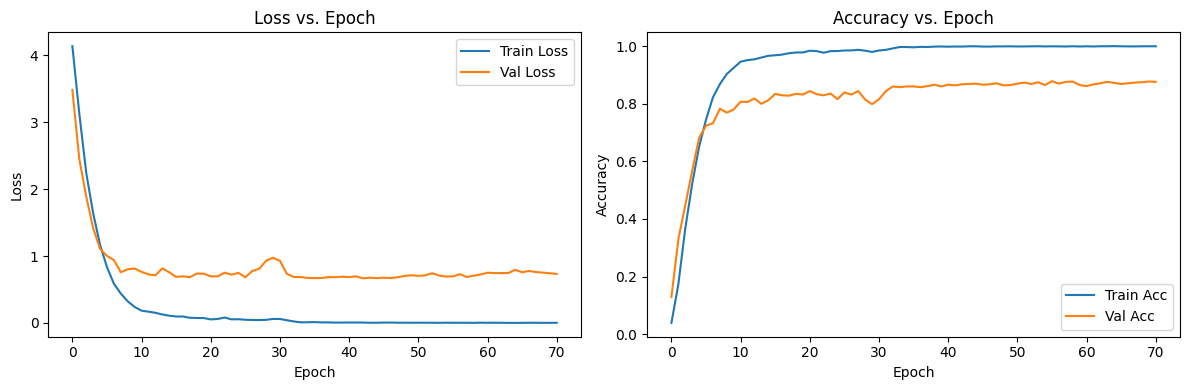

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simpler but effective data augmentation
transform_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Modified VGG16 model
class ModifiedVGG16(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedVGG16, self).__init__()
        # Load pre-trained VGG16 with weights parameter
        self.vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # Modify first layer for grayscale
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        # Modify classifier
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

def load_data(data_dir):
    image_paths, labels = [], []
    for user in os.listdir(data_dir):
        user_folder = os.path.join(data_dir, user)
        if os.path.isdir(user_folder):
            images = glob.glob(os.path.join(user_folder, "*.png"))
            image_paths.extend(images)
            labels.extend([user] * len(images))

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
    test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, len(label_encoder.classes_)

def train_model(model, train_loader, val_loader, num_epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.vgg.features.parameters(), 'lr': 1e-5},
        {'params': model.vgg.classifier.parameters(), 'lr': 1e-4}
    ])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / total

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
            patience_counter = 0
            print("Model checkpoint saved!")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return history

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return test_loss, test_acc

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    train_loader, val_loader, test_loader, num_classes = load_data("isolated_words_per_user")

    # Initialize model
    model = ModifiedVGG16(num_classes=num_classes).to(device)

    # Train model
    history = train_model(model, train_loader, val_loader)

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    test_loss, test_acc = evaluate_model(model, test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()

Same code as the previous cell but with a smaller number of epochs (10 epochs). shows good results with 76% accuracy

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.0MB/s]


Epoch 1/10:
Train Loss: 4.1327, Train Acc: 0.0396
Val Loss: 3.5741, Val Acc: 0.0885
Model checkpoint saved!
Epoch 2/10:
Train Loss: 3.2644, Train Acc: 0.1452
Val Loss: 2.6425, Val Acc: 0.2875
Model checkpoint saved!
Epoch 3/10:
Train Loss: 2.3579, Train Acc: 0.3345
Val Loss: 1.9473, Val Acc: 0.4349
Model checkpoint saved!
Epoch 4/10:
Train Loss: 1.6943, Train Acc: 0.5082
Val Loss: 1.5504, Val Acc: 0.5504
Model checkpoint saved!
Epoch 5/10:
Train Loss: 1.2355, Train Acc: 0.6390
Val Loss: 1.2171, Val Acc: 0.6450
Model checkpoint saved!
Epoch 6/10:
Train Loss: 0.8844, Train Acc: 0.7365
Val Loss: 1.0204, Val Acc: 0.6929
Model checkpoint saved!
Epoch 7/10:
Train Loss: 0.6330, Train Acc: 0.8063
Val Loss: 0.8474, Val Acc: 0.7482
Model checkpoint saved!
Epoch 8/10:
Train Loss: 0.4613, Train Acc: 0.8588
Val Loss: 0.8820, Val Acc: 0.7654
Model checkpoint saved!
Epoch 9/10:
Train Loss: 0.3657, Train Acc: 0.8887
Val Loss: 0.7820, Val Acc: 0.7826
Model checkpoint saved!
Epoch 10/10:
Train Loss: 0.2

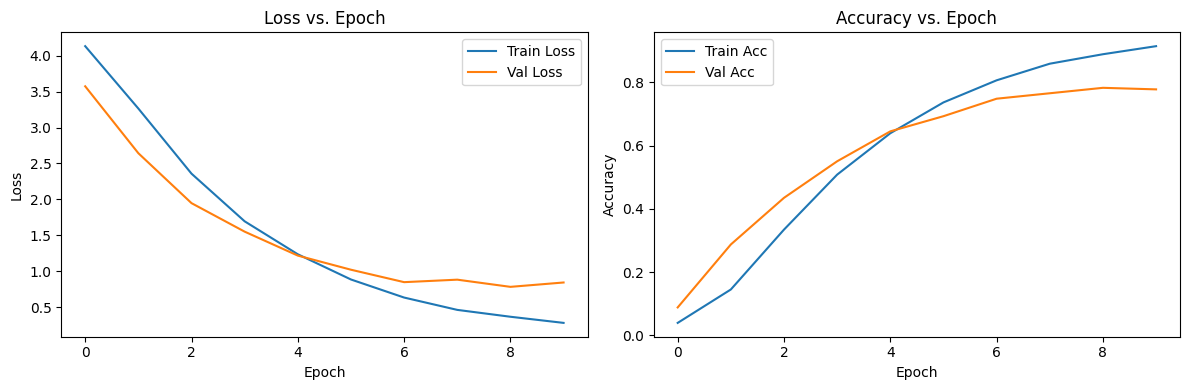

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simpler but effective data augmentation
transform_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Modified VGG16 model
class ModifiedVGG16(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedVGG16, self).__init__()
        # Load pre-trained VGG16 with weights parameter
        self.vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # Modify first layer for grayscale
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        # Modify classifier
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

def load_data(data_dir):
    image_paths, labels = [], []
    for user in os.listdir(data_dir):
        user_folder = os.path.join(data_dir, user)
        if os.path.isdir(user_folder):
            images = glob.glob(os.path.join(user_folder, "*.png"))
            image_paths.extend(images)
            labels.extend([user] * len(images))

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
    test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, len(label_encoder.classes_)

def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.vgg.features.parameters(), 'lr': 1e-5},
        {'params': model.vgg.classifier.parameters(), 'lr': 1e-4}
    ])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / total

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
            patience_counter = 0
            print("Model checkpoint saved!")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return history

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return test_loss, test_acc

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    train_loader, val_loader, test_loader, num_classes = load_data("isolated_words_per_user")

    # Initialize model
    model = ModifiedVGG16(num_classes=num_classes).to(device)

    # Train model
    history = train_model(model, train_loader, val_loader)

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    test_loss, test_acc = evaluate_model(model, test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()

**ResNet101**

The model starts with ResNet101's Pre-trained weights, which already encode rich visual features learned from ImageNet dataset. This reduces the need for large training data and extensive training time.
in this approach instead of freezing the feature extraction layers, the entire model (including pre-trained layers) is fine-tuned to adapt to the new dataset of the handwritten data.

Transfer learning with a pre-trained ResNet model has produced excellent results, achieving 89% accuracy on the test set, which is higher than the VGG16 model while requiring similar computational time.
The accuracy shows a strong and steady improvement over the epochs, with both training and validation accuracy curves converging closely, indicating that the model is generalizing well to the dataset.
The loss steadily decreases throughout the epochs, further suggesting effective fine-tuning.
These results significantly outperform the results from Task 3, showcasing the superiority of ResNet for this task.

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 145MB/s]


Epoch 1/10:
Train Loss: 3.6844, Train Acc: 0.1409
Val Loss: 2.5172, Val Acc: 0.3096
Model checkpoint saved!
Epoch 2/10:
Train Loss: 1.8963, Train Acc: 0.4660
Val Loss: 1.5295, Val Acc: 0.5369
Model checkpoint saved!
Epoch 3/10:
Train Loss: 1.1650, Train Acc: 0.6536
Val Loss: 1.0894, Val Acc: 0.6486
Model checkpoint saved!
Epoch 4/10:
Train Loss: 0.7433, Train Acc: 0.7870
Val Loss: 0.7306, Val Acc: 0.7826
Model checkpoint saved!
Epoch 5/10:
Train Loss: 0.4626, Train Acc: 0.8689
Val Loss: 0.5237, Val Acc: 0.8415
Model checkpoint saved!
Epoch 6/10:
Train Loss: 0.2985, Train Acc: 0.9176
Val Loss: 0.5103, Val Acc: 0.8501
Model checkpoint saved!
Epoch 7/10:
Train Loss: 0.2071, Train Acc: 0.9484
Val Loss: 0.4411, Val Acc: 0.8612
Model checkpoint saved!
Epoch 8/10:
Train Loss: 0.1529, Train Acc: 0.9599
Val Loss: 0.4687, Val Acc: 0.8624
Model checkpoint saved!
Epoch 9/10:
Train Loss: 0.1274, Train Acc: 0.9644
Val Loss: 0.3310, Val Acc: 0.8993
Model checkpoint saved!
Epoch 10/10:
Train Loss: 0.1

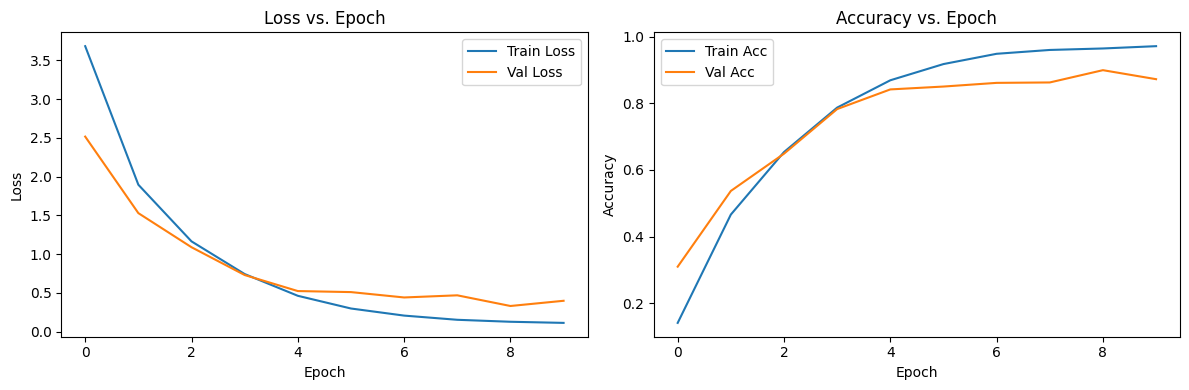

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simpler but effective data augmentation
transform_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Modified ResNet101 model
class ModifiedResNet101(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet101, self).__init__()
        # Load pre-trained ResNet101 with weights
        self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # Modify the first convolutional layer for grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

def load_data(data_dir):
    image_paths, labels = [], []
    for user in os.listdir(data_dir):
        user_folder = os.path.join(data_dir, user)
        if os.path.isdir(user_folder):
            images = glob.glob(os.path.join(user_folder, "*.png"))
            image_paths.extend(images)
            labels.extend([user] * len(images))

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
    test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, len(label_encoder.classes_)

def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.resnet.parameters(), 'lr': 1e-4}
    ])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / total

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
            patience_counter = 0
            print("Model checkpoint saved!")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return history

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return test_loss, test_acc

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    train_loader, val_loader, test_loader, num_classes = load_data("isolated_words_per_user")

    # Initialize model
    model = ModifiedResNet101(num_classes=num_classes).to(device)

    # Train model
    history = train_model(model, train_loader, val_loader)

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    test_loss, test_acc = evaluate_model(model, test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()


100 epochs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simpler but effective data augmentation
transform_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Modified ResNet101 model
class ModifiedResNet101(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet101, self).__init__()
        # Load pre-trained ResNet101 with weights
        self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # Modify the first convolutional layer for grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

def load_data(data_dir):
    image_paths, labels = [], []
    for user in os.listdir(data_dir):
        user_folder = os.path.join(data_dir, user)
        if os.path.isdir(user_folder):
            images = glob.glob(os.path.join(user_folder, "*.png"))
            image_paths.extend(images)
            labels.extend([user] * len(images))

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
    test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, len(label_encoder.classes_)

def train_model(model, train_loader, val_loader, num_epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.resnet.parameters(), 'lr': 1e-4}
    ])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / total

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
            patience_counter = 0
            print("Model checkpoint saved!")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return history

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return test_loss, test_acc

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    train_loader, val_loader, test_loader, num_classes = load_data("isolated_words_per_user")

    # Initialize model
    model = ModifiedResNet101(num_classes=num_classes).to(device)

    # Train model
    history = train_model(model, train_loader, val_loader)

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    test_loss, test_acc = evaluate_model(model, test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 128MB/s]


Epoch 1/100:
Train Loss: 3.6351, Train Acc: 0.1377
Val Loss: 2.8301, Val Acc: 0.2138
Model checkpoint saved!
Epoch 2/100:
Train Loss: 1.8988, Train Acc: 0.4754
Val Loss: 1.4568, Val Acc: 0.5688
Model checkpoint saved!
Epoch 3/100:
Train Loss: 1.1382, Train Acc: 0.6741
Val Loss: 1.0289, Val Acc: 0.6941
Model checkpoint saved!
Epoch 4/100:
Train Loss: 0.6855, Train Acc: 0.8081
Val Loss: 0.7313, Val Acc: 0.7752
Model checkpoint saved!
Epoch 5/100:
Train Loss: 0.4154, Train Acc: 0.8852
Val Loss: 0.6078, Val Acc: 0.8243
Model checkpoint saved!
Epoch 6/100:
Train Loss: 0.2593, Train Acc: 0.9322
Val Loss: 0.4857, Val Acc: 0.8636
Model checkpoint saved!
Epoch 7/100:
Train Loss: 0.1796, Train Acc: 0.9561
Val Loss: 0.4057, Val Acc: 0.8636
Epoch 8/100:
Train Loss: 0.1425, Train Acc: 0.9618
Val Loss: 0.4184, Val Acc: 0.8747
Model checkpoint saved!



Same as previous cell, but more fine tuned still shows great results, not worth the extra computational resources and time needed to train  

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Training resnet101:
Epoch 1/50:
Train Loss: 4.3935, Train Acc: 0.0170
Val Loss: 4.3221, Val Acc: 0.0651
Model checkpoint saved!
Epoch 2/50:
Train Loss: 4.1092, Train Acc: 0.0580
Val Loss: 3.7680, Val Acc: 0.0958
Model checkpoint saved!
Epoch 3/50:
Train Loss: 3.5763, Train Acc: 0.1102
Val Loss: 3.1862, Val Acc: 0.2113
Model checkpoint saved!
Epoch 4/50:
Train Loss: 3.2118, Train Acc: 0.1722
Val Loss: 2.8856, Val Acc: 0.2617
Model checkpoint saved!
Epoch 5/50:
Train Loss: 2.9017, Train Acc: 0.2332
Val Loss: 2.5617, Val Acc: 0.3243
Model checkpoint saved!
Epoch 6/50:
Train Loss: 2.6410, Train Acc: 0.2820
Val Loss: 2.3612, Val Acc: 0.3624
Model checkpoint saved!
Epoch 7/50:
Train Loss: 2.4047, Train Acc: 0.3487
Val Loss: 2.0985, Val Acc: 0.4238
Model checkpoint saved!
Epoch 8/50:
Train Loss: 2.1603, Train Acc: 0.4009
Val Loss: 1.8531, Val Acc: 0.4840
Model checkpoint saved!
Epoch 9/50:
Train Loss: 1.9568, Train Acc: 0.4542
Val Loss: 1.6917, Val Acc: 0.5307
Model checkpoint saved!
Epoch 1

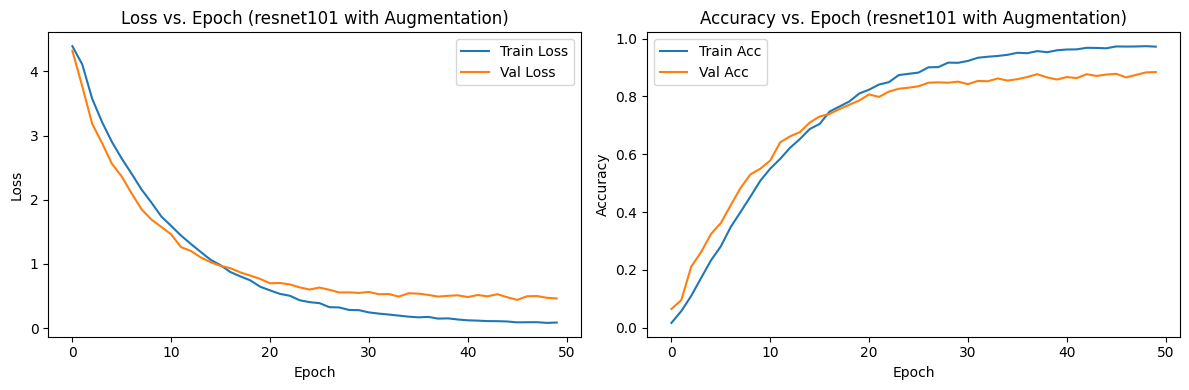

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Augmentation Transforms
transform_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

class ModifiedResNet(nn.Module):
    def __init__(self, num_classes, resnet_version='resnet101'):
        super(ModifiedResNet, self).__init__()

        # Load pre-trained ResNet based on version
        if resnet_version == 'resnet101':
            self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        else:
            raise ValueError("Unsupported ResNet version. Choose 'resnet101'.")

        # Modify first layer for grayscale
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

def load_data(data_dir):
    image_paths, labels = [], []
    for user in os.listdir(data_dir):
        user_folder = os.path.join(data_dir, user)
        if os.path.isdir(user_folder):
            images = glob.glob(os.path.join(user_folder, "*.png"))
            image_paths.extend(images)
            labels.extend([user] * len(images))

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
    test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, len(label_encoder.classes_)

def train_model(model, train_loader, val_loader, resnet_version, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model.resnet.conv1.parameters(), 'lr': 1e-5},
        {'params': model.resnet.layer1.parameters(), 'lr': 1e-5},
        {'params': model.resnet.layer2.parameters(), 'lr': 1e-5},
        {'params': model.resnet.layer3.parameters(), 'lr': 1e-5},
        {'params': model.resnet.layer4.parameters(), 'lr': 1e-5},
        {'params': model.resnet.fc.parameters(), 'lr': 1e-4}
    ])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / total

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_{resnet_version}.pth', _use_new_zipfile_serialization=False)
            patience_counter = 0
            print("Model checkpoint saved!")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return history

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return test_loss, test_acc

def plot_training_history(history, resnet_version):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'Loss vs. Epoch ({resnet_version} with Augmentation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'Accuracy vs. Epoch ({resnet_version} with Augmentation)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    train_loader, val_loader, test_loader, num_classes = load_data("isolated_words_per_user")

    # Compare ResNet101 and ResNet152
    resnet_versions = ['resnet101']
    results = {}

    for version in resnet_versions:
        print(f"\nTraining {version}:")
        # Initialize model
        model = ModifiedResNet(num_classes=num_classes, resnet_version= version).to(device)

        # Train model
        history = train_model(model, train_loader, val_loader, version)

        # Load best model and evaluate
        model.load_state_dict(torch.load(f'best_model_{version}.pth', weights_only=True))
        test_loss, test_acc = evaluate_model(model, test_loader)

        print(f'{version} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Store results
        results[version] = {
            'history': history,
            'test_loss': test_loss,
            'test_acc': test_acc
        }

        # Plot training history
        plot_training_history(history, version)



if __name__ == "__main__":
    main()

ResNet101 with freezing more layers

In this approach we want to gradually unfreeze earlier layers during training "gradual unfreezing". This could allow the model to adapt its low- and mid-level features to the dataset in later stages of training.  theoratically a better approach to transfer but the first (single phase ) is much simpler and showed great results



The two approaches for transfer learning differ in complexity and effectiveness. The first approach, using a single phase of training with frozen layers, is faster and simpler, achieving impressive results with high accuracy (89%) after just 10 epochs. It is computationally efficient and delivers stable performance, making it a good choice when quick results are needed. On the other hand, the second approach, involving gradual unfreezing of earlier layers, allows for more detailed adaptation to the dataset over 70 epochs. While this approach is more computationally expensive and slower, it leads to more stable improvements over time and has the potential for even better performance with enough training. In terms of accuracy and generalization, the gradual unfreezing approach may eventually outperform the first, but the simpler, faster approach offers a practical and efficient solution for quick deployment.

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Stage 0, Epoch 1:
Train Loss: 4.4058, Train Acc: 0.0155
Val Loss: 4.2805, Val Acc: 0.0344
Model checkpoint saved!
Stage 0, Epoch 2:
Train Loss: 4.2333, Train Acc: 0.0285
Val Loss: 3.9926, Val Acc: 0.0491
Model checkpoint saved!
Stage 0, Epoch 3:
Train Loss: 4.0498, Train Acc: 0.0464
Val Loss: 3.8279, Val Acc: 0.0786
Model checkpoint saved!
Stage 0, Epoch 4:
Train Loss: 3.9715, Train Acc: 0.0496
Val Loss: 3.7756, Val Acc: 0.0713
Stage 0, Epoch 5:
Train Loss: 3.9185, Train Acc: 0.0692
Val Loss: 3.8074, Val Acc: 0.0823
Model checkpoint saved!
Stage 0, Epoch 6:
Train Loss: 3.8812, Train Acc: 0.0654
Val Loss: 3.6783, Val Acc: 0.0897
Model checkpoint saved!
Stage 0, Epoch 7:
Train Loss: 3.8489, Train Acc: 0.0662
Val Loss: 3.6782, Val Acc: 0.1020
Model checkpoint saved!
Stage 0, Epoch 8:
Train Loss: 3.8317, Train Acc: 0.0691
Val Loss: 3.6704, Val Acc: 0.0848
Stage 0, Epoch 9:
Train Loss: 3.8072, Train Acc: 0.0815
Val Loss: 3.5920, Val Acc: 0.1143
Model checkpoint saved!
Stage 0, Epoch 10:
Tra

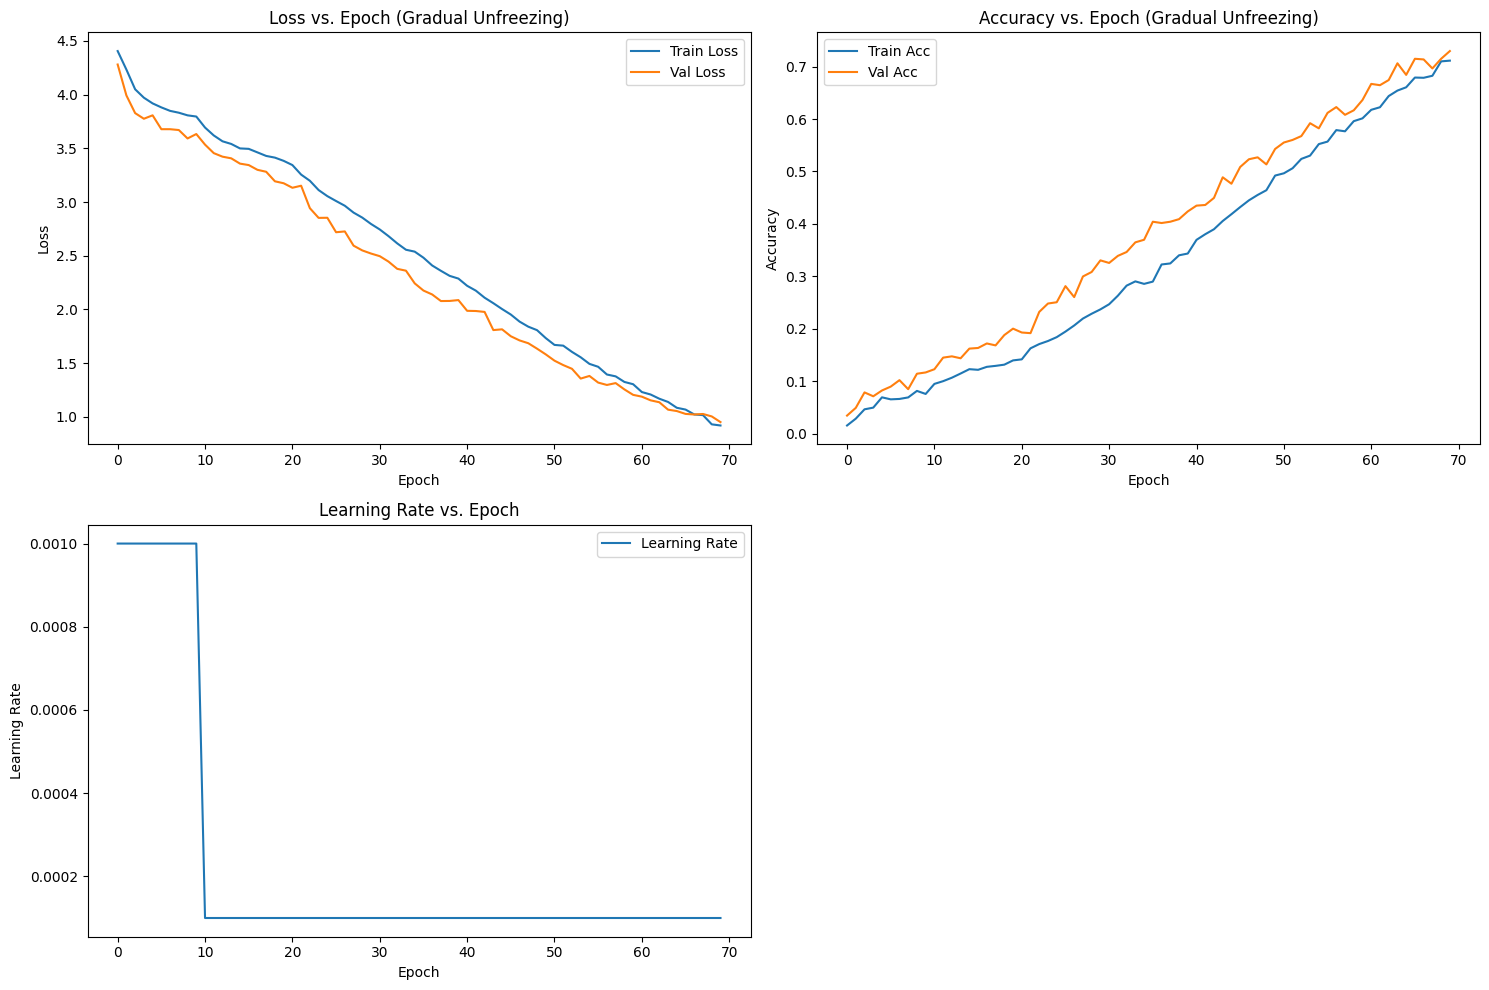

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check for available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Gradual Unfreezing Data Augmentation
transform_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_no_augmentation = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

class GradualUnfreezingResNet101(nn.Module):
    def __init__(self, num_classes):
        super(GradualUnfreezingResNet101, self).__init__()
        # Load pre-trained ResNet101
        self.resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # Modify the first convolutional layer for grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Custom classification head
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # Unfreeze classification layers
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def unfreeze_layers(self, stage):
        """
        Gradually unfreeze layers based on the current training stage
        Stages:
        0: Only FC layers (initial state)
        1: Unfreeze layer4
        2: Unfreeze layer3
        3: Unfreeze layer2
        4: Unfreeze layer1
        5: Unfreeze initial layers
        """
        # Always keep FC layers trainable
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

        # Progressively unfreeze layers
        if stage >= 1:
            for param in self.resnet.layer4.parameters():
                param.requires_grad = True
        if stage >= 2:
            for param in self.resnet.layer3.parameters():
                param.requires_grad = True
        if stage >= 3:
            for param in self.resnet.layer2.parameters():
                param.requires_grad = True
        if stage >= 4:
            for param in self.resnet.layer1.parameters():
                param.requires_grad = True
        if stage >= 5:
            self.resnet.conv1.requires_grad_(True)
            self.resnet.bn1.requires_grad_(True)

    def forward(self, x):
        return self.resnet(x)

def load_data(data_dir):
    image_paths, labels = [], []
    for user in os.listdir(data_dir):
        user_folder = os.path.join(data_dir, user)
        if os.path.isdir(user_folder):
            images = glob.glob(os.path.join(user_folder, "*.png"))
            image_paths.extend(images)
            labels.extend([user] * len(images))

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    train_dataset = CustomDataset(X_train, y_train, transform=transform_augmentation)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_no_augmentation)
    test_dataset = CustomDataset(X_test, y_test, transform=transform_no_augmentation)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, len(label_encoder.classes_)

def train_model(model, train_loader, val_loader, num_epochs=100):
    # Gradual unfreezing strategy
    unfreezing_stages = [
        {'stage': 0, 'epochs': 10, 'lr_fc': 1e-3, 'lr_backbone': 0},
        {'stage': 1, 'epochs': 10, 'lr_fc': 1e-4, 'lr_backbone': 1e-5},
        {'stage': 2, 'epochs': 10, 'lr_fc': 1e-4, 'lr_backbone': 1e-5},
        {'stage': 3, 'epochs': 10, 'lr_fc': 1e-4, 'lr_backbone': 1e-5},
        {'stage': 4, 'epochs': 10, 'lr_fc': 1e-4, 'lr_backbone': 1e-5},
        {'stage': 5, 'epochs': 20, 'lr_fc': 1e-4, 'lr_backbone': 1e-5}
    ]

    criterion = nn.CrossEntropyLoss()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'lr': []
    }

    best_val_acc = 0
    patience = 15
    patience_counter = 0
    global_epoch = 0

    # Iterate through unfreezing stages
    for stage_config in unfreezing_stages:
        # Unfreeze layers for this stage
        model.unfreeze_layers(stage_config['stage'])

        # Prepare optimizer with different learning rates
        fc_params = [p for p in model.resnet.fc.parameters() if p.requires_grad]
        backbone_params = [p for name, p in model.resnet.named_parameters() if p.requires_grad and "fc" not in name]

        optimizer = optim.Adam([
            {'params': fc_params, 'lr': stage_config['lr_fc']},
            {'params': backbone_params, 'lr': stage_config['lr_backbone']}
        ])

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

        # Train for specified number of epochs in this stage
        for _ in range(stage_config['epochs']):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            total = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()

            train_loss = train_loss / len(train_loader)
            train_acc = train_correct / total

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

            val_loss = val_loss / len(val_loader)
            val_acc = val_correct / total

            # Update scheduler
            scheduler.step(val_acc)

            # Save history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['lr'].append(optimizer.param_groups[0]['lr'])

            print(f'Stage {stage_config["stage"]}, Epoch {global_epoch+1}:')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'best_gradual_unfreeze_model.pth', _use_new_zipfile_serialization=False)
                patience_counter = 0
                print("Model checkpoint saved!")
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

            global_epoch += 1

    return history

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return test_loss, test_acc

def plot_training_history(history):
    plt.figure(figsize=(15, 10))

    # Loss subplot
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch (Gradual Unfreezing)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch (Gradual Unfreezing)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Learning Rate subplot
    plt.subplot(2, 2, 3)
    plt.plot(history['lr'], label='Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    train_loader, val_loader, test_loader, num_classes = load_data("isolated_words_per_user")

    # Initialize model with gradual unfreezing
    model = GradualUnfreezingResNet101(num_classes=num_classes).to(device)

    # Train model
    history = train_model(model, train_loader, val_loader)

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_gradual_unfreeze_model.pth', weights_only=True))
    test_loss, test_acc = evaluate_model(model, test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()

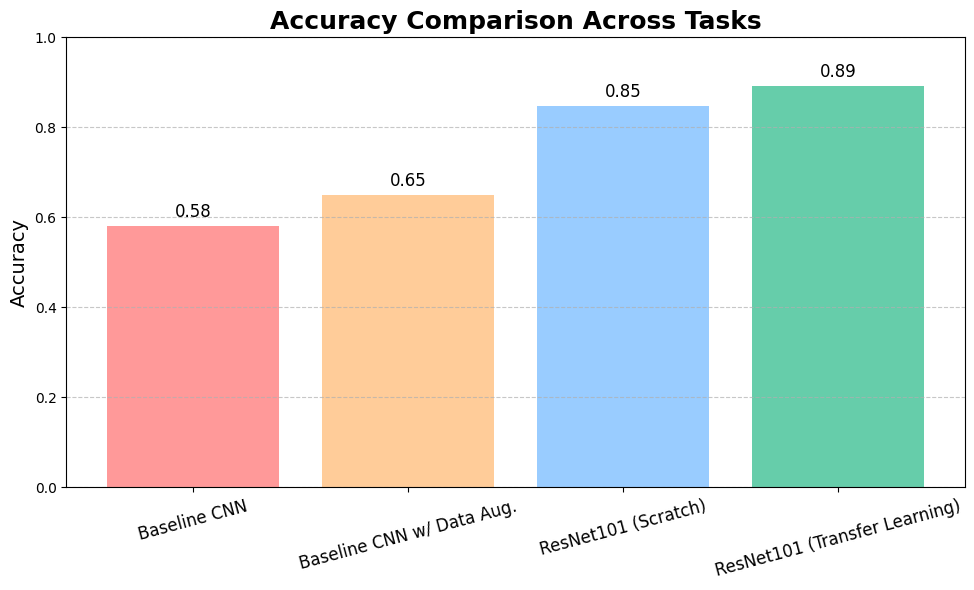

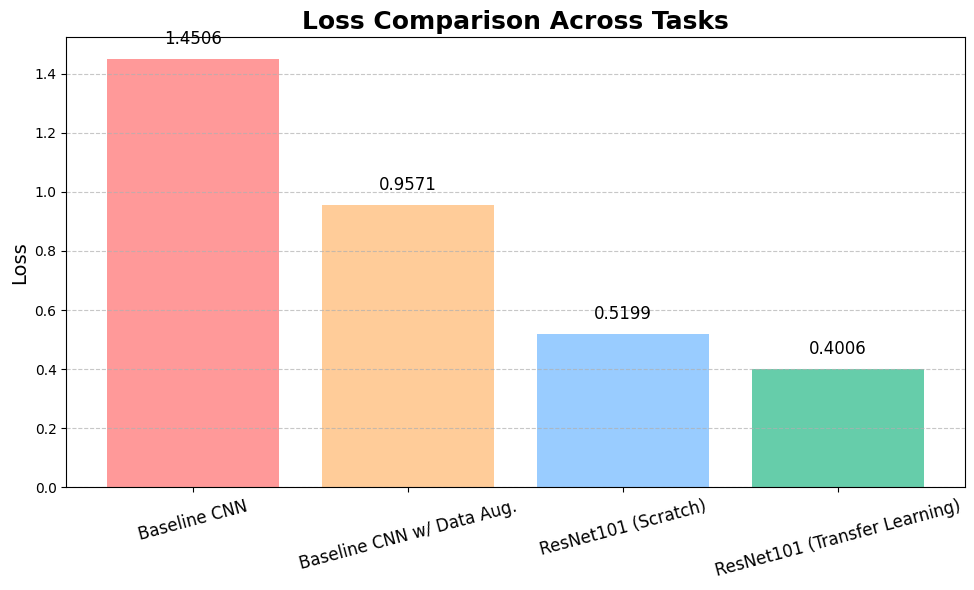

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = [
    "Baseline CNN",
    "Baseline CNN w/ Data Aug.",
    "ResNet101 (Scratch)",
    "ResNet101 (Transfer Learning)"
]
accuracies = [0.5810, 0.6500, 0.8479, 0.8920]
losses = [1.4506, 0.9571, 0.5199, 0.4006]

# Plot 1: Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(tasks, accuracies, color=['#FF9999', '#FFCC99', '#99CCFF', '#66CDAA'])
plt.title("Accuracy Comparison Across Tasks", fontsize=18, weight='bold')
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.xticks(fontsize=12, rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Loss Comparison
plt.figure(figsize=(10, 6))
plt.bar(tasks, losses, color=['#FF9999', '#FFCC99', '#99CCFF', '#66CDAA'])
plt.title("Loss Comparison Across Tasks", fontsize=18, weight='bold')
plt.ylabel("Loss", fontsize=14)
for i, v in enumerate(losses):
    plt.text(i, v + 0.05, f"{v:.4f}", ha='center', fontsize=12)
plt.xticks(fontsize=12, rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


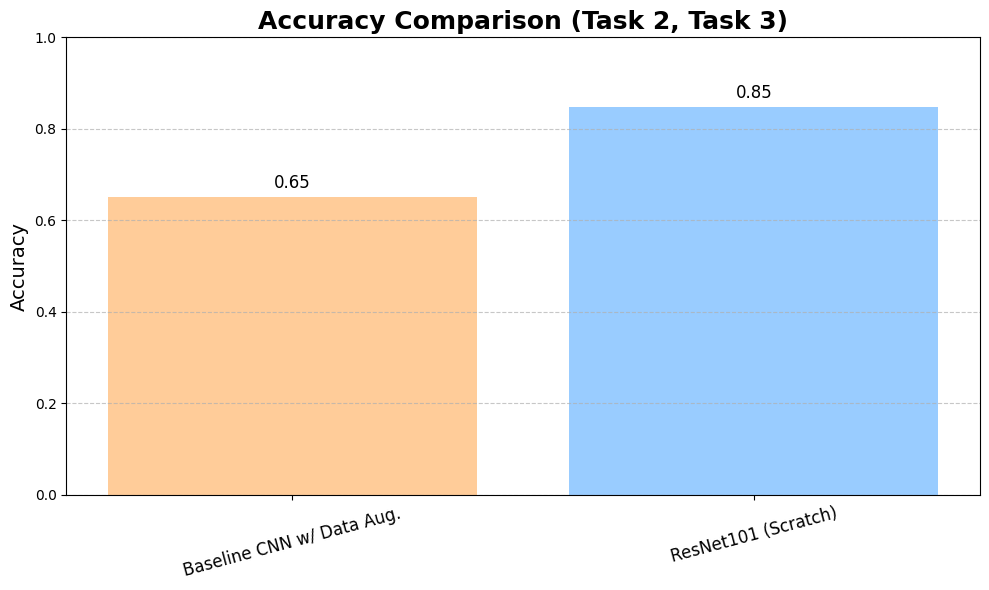

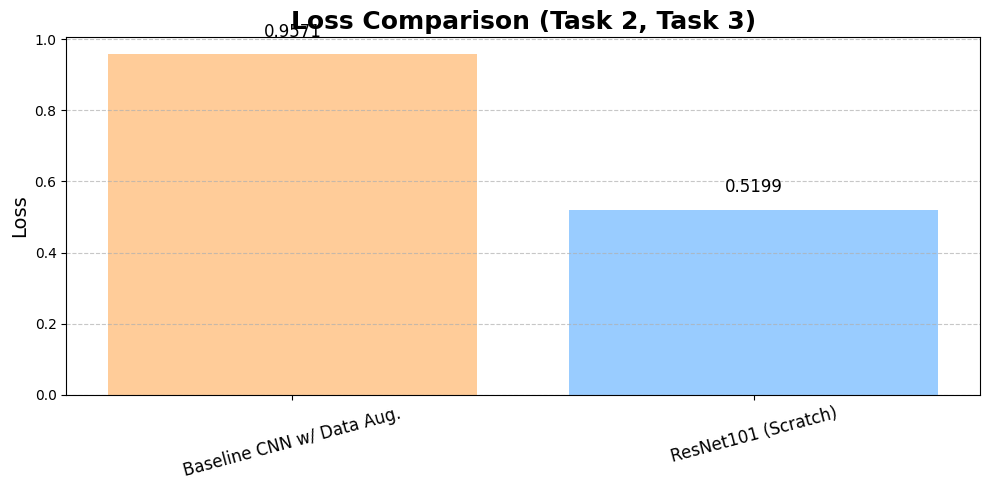

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = [
    "Baseline CNN w/ Data Aug.",
    "ResNet101 (Scratch)"
]
accuracies = [ 0.6500, 0.8479]
losses = [ 0.9571, 0.5199]

# Plot 1: Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(tasks, accuracies, color=['#FFCC99', '#99CCFF'])
plt.title("Accuracy Comparison (Task 2, Task 3)", fontsize=18, weight='bold')
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.xticks(fontsize=12, rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Loss Comparison
plt.figure(figsize=(10, 5))
plt.bar(tasks, losses, color=[ '#FFCC99', '#99CCFF'])
plt.title("Loss Comparison (Task 2, Task 3)", fontsize=18, weight='bold')
plt.ylabel("Loss", fontsize=14)
for i, v in enumerate(losses):
    plt.text(i, v + 0.05, f"{v:.4f}", ha='center', fontsize=12)
plt.xticks(fontsize=12, rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


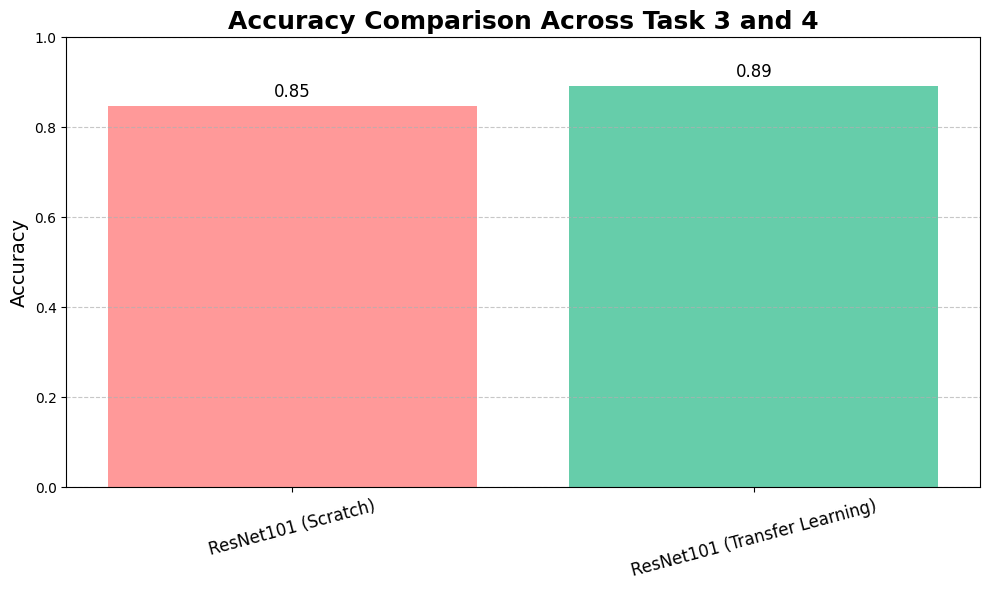

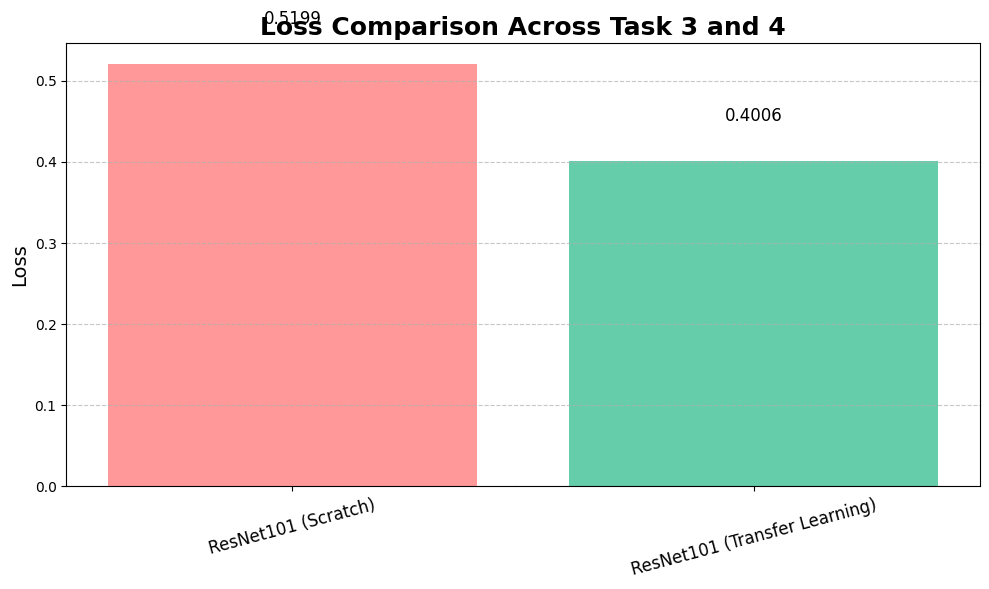

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = [
    "ResNet101 (Scratch)",
    "ResNet101 (Transfer Learning)"
]
accuracies = [ 0.8479, 0.8920]
losses = [0.5199, 0.4006]

# Plot 1: Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(tasks, accuracies, color=['#FF9999', '#66CDAA'])
plt.title("Accuracy Comparison Across Task 3 and 4", fontsize=18, weight='bold')
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.xticks(fontsize=12, rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Loss Comparison
plt.figure(figsize=(10, 6))
plt.bar(tasks, losses, color=['#FF9999', '#66CDAA'])
plt.title("Loss Comparison Across Task 3 and 4", fontsize=18, weight='bold')
plt.ylabel("Loss", fontsize=14)
for i, v in enumerate(losses):
    plt.text(i, v + 0.05, f"{v:.4f}", ha='center', fontsize=12)
plt.xticks(fontsize=12, rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
